In [81]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nbformat
import nest_asyncio
import pyshark
from tqdm import tqdm

nest_asyncio.apply()

In [82]:
def pcap_to_dataframe(pcap_file):
    cap = pyshark.FileCapture(pcap_file)
    packet_data = []
    
    for packet in tqdm(cap, desc="Reading packets from PCAP"):
        packet_info = {}

        try:
            packet_info['timestamp'] = packet.sniff_time
            packet_info['length'] = packet.length

            if hasattr(packet, 'eth'):
                packet_info['eth_src'] = packet.eth.src
                packet_info['eth_dst'] = packet.eth.dst

            if hasattr(packet, 'ip'):
                packet_info['ip_src'] = packet.ip.src
                packet_info['ip_dst'] = packet.ip.dst
                packet_info['ip_version'] = packet.ip.version
                packet_info['ip_ihl'] = packet.ip.hdr_len
                packet_info['ip_tos'] = packet.ip.dsfield
                packet_info['ip_ttl'] = packet.ip.ttl
                packet_info['ip_protocol'] = packet.ip.proto
                packet_info['ip_flags'] = packet.ip.flags

            if hasattr(packet, 'tcp'):
                packet_info['tcp_srcport'] = packet.tcp.srcport
                packet_info['tcp_dstport'] = packet.tcp.dstport
                packet_info['tcp_seq'] = packet.tcp.seq
                packet_info['tcp_ack'] = packet.tcp.ack
                packet_info['tcp_flags'] = packet.tcp.flags

            if hasattr(packet, 'udp'):
                packet_info['udp_srcport'] = packet.udp.srcport
                packet_info['udp_dstport'] = packet.udp.dstport
                packet_info['udp_length'] = packet.udp.length

            if hasattr(packet, 'dns'):
                packet_info['dns_query'] = packet.dns.qry_name
                packet_info['dns_query_type'] = packet.dns.qry_type

            if hasattr(packet, 'http'):
                packet_info['http_method'] = packet.http.request_method
                packet_info['http_host'] = packet.http.host
                packet_info['http_uri'] = packet.http.request_uri
                packet_info['http_user_agent'] = packet.http.user_agent

            packet_info['raw_info'] = str(packet)

        except AttributeError:
            continue

        packet_data.append(packet_info)

    df = pd.DataFrame(packet_data)
    return df

def save_to_csv(df, output_csv):
    df.to_csv(output_csv, index=False)
    print(f"Data successfully written to {output_csv}")

if __name__ == "__main__":
    pcap_file = "data.pcap"
    output_csv = "output.csv"
    df = pcap_to_dataframe(pcap_file)
    save_to_csv(df, output_csv)

df = pd.read_csv('output.csv')

labels = pd.read_csv('data.csv', header=None, names=['label_data'])
labels[['index', 'label']] = labels['label_data'].str.split(';', expand=True)
labels.drop('label_data', axis=1, inplace=True)
labels['index'] = pd.to_numeric(labels['index'])

df.reset_index(inplace=True)

merged_df = pd.merge(df, labels, left_on='index', right_on='index')
merged_df.drop('index', axis=1, inplace=True)
merged_df.fillna(0,inplace=True)
dfp = merged_df.copy()


Reading packets from PCAP: 12296it [00:20, 598.82it/s]


Data successfully written to output.csv


In [83]:
hex_cols = ['eth_src', 'eth_dst', 'ip_src', 'ip_dst']
for col in hex_cols:
    if col in dfp.columns:
        dfp[col] = dfp[col].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)

label_encoder = LabelEncoder()
categorical_cols = ['eth_src', 'eth_dst', 'ip_src', 'ip_dst', 'ip_protocol', 'http_method']
for col in categorical_cols:
    if col in dfp.columns:
        dfp[col] = label_encoder.fit_transform(dfp[col].astype(str))

scaler = StandardScaler()
numerical_cols = ['length', 'ip_ihl', 'ip_tos', 'ip_ttl', 'tcp_seq', 'tcp_ack', 'udp_length']

for col in numerical_cols:
    if col in dfp.columns:
        dfp[col] = pd.to_numeric(dfp[col], errors='coerce')

dfp[numerical_cols] = scaler.fit_transform(dfp[numerical_cols])

print(dfp.isnull().sum())
dfp.drop(columns=['ip_tos'], inplace=True)
dfp.fillna(0, inplace=True)


timestamp          0
length             0
eth_src            0
eth_dst            0
raw_info           0
ip_src             0
ip_dst             0
ip_version         0
ip_ihl             0
ip_tos         12276
ip_ttl             0
ip_protocol        0
ip_flags           0
tcp_srcport        0
tcp_dstport        0
tcp_seq            0
tcp_ack            0
tcp_flags          0
udp_srcport        0
udp_dstport        0
udp_length         0
label              0
dtype: int64


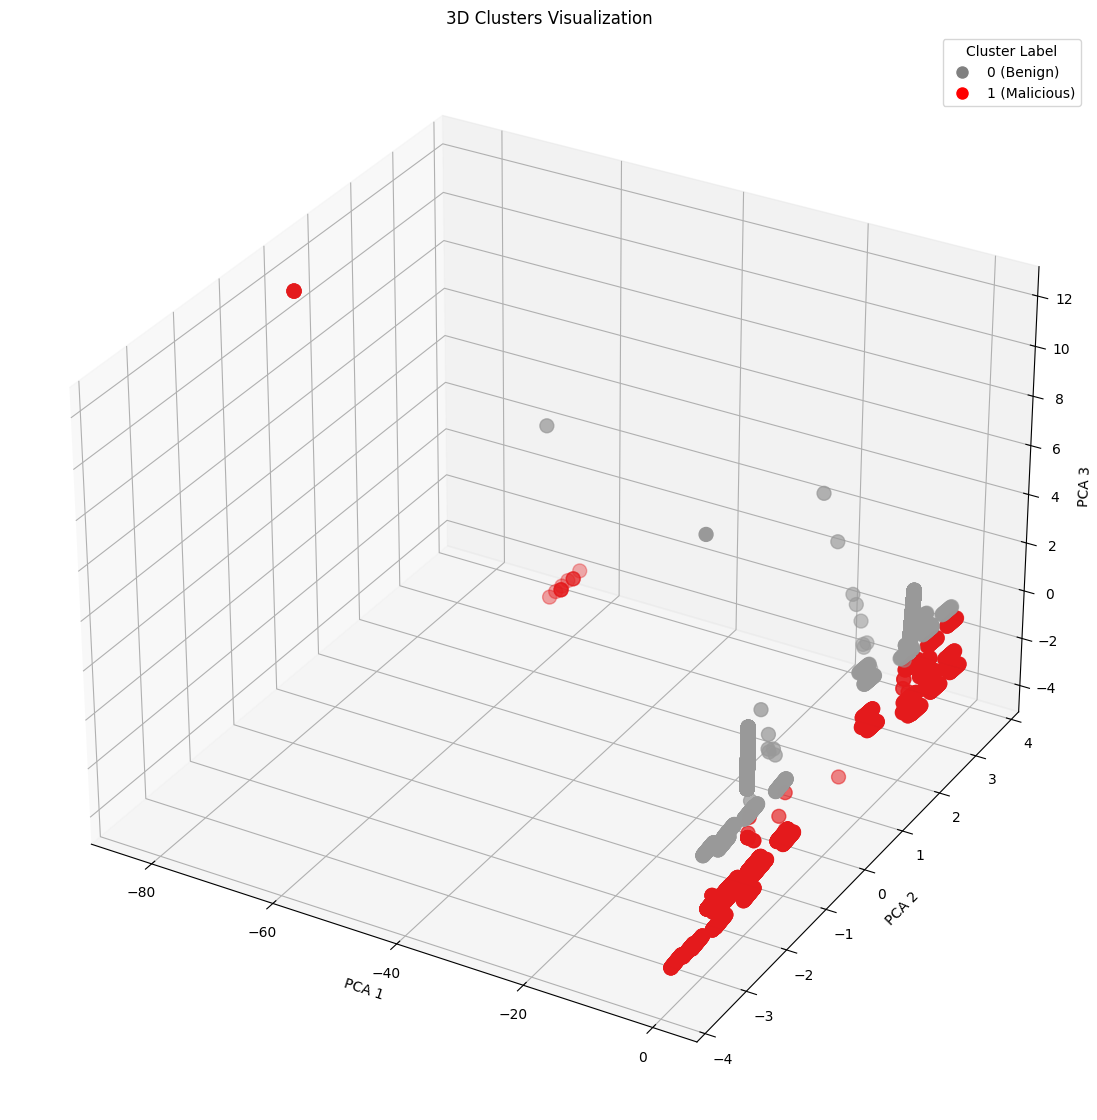

In [84]:
if 'timestamp' in dfp.columns:
    dfp['hour'] = pd.to_datetime(dfp['timestamp'], errors='coerce').dt.hour
    dfp['minute'] = pd.to_datetime(dfp['timestamp'], errors='coerce').dt.minute
    dfp['second'] = pd.to_datetime(dfp['timestamp'], errors='coerce').dt.second
    dfp.drop(columns=['timestamp'], inplace=True)

dfp['large_packet'] = dfp['length'].apply(lambda x: 1 if x > 1000 else 0)

label_encoder = LabelEncoder()
categorical_cols = ['eth_src', 'eth_dst', 'ip_src', 'ip_dst', 'ip_protocol', 'http_method']
for col in categorical_cols:
    if col in dfp.columns:
        dfp[col] = label_encoder.fit_transform(dfp[col].astype(str))

if 'tcp_flags' in dfp.columns:
    dfp['tcp_flags'] = dfp['tcp_flags'].astype(str)
    dfp['tcp_flag_fin'] = dfp['tcp_flags'].apply(lambda x: int(x, 16) & 0x01 if pd.notnull(x) else 0)
    dfp['tcp_flag_syn'] = dfp['tcp_flags'].apply(lambda x: int(x, 16) & 0x02 if pd.notnull(x) else 0)
    dfp['tcp_flag_ack'] = dfp['tcp_flags'].apply(lambda x: int(x, 16) & 0x10 if pd.notnull(x) else 0)

if 'ip_src' in dfp.columns:
    ip_aggregated = dfp.groupby('ip_src').agg({'length': 'sum', 'tcp_seq': 'count'}).reset_index()
    ip_aggregated.rename(columns={'length': 'length_sum', 'tcp_seq': 'packet_count'}, inplace=True)
    dfp = dfp.merge(ip_aggregated, how='left', on='ip_src', suffixes=('', '_ip_agg'))

if all(col in dfp.columns for col in ['length_sum', 'packet_count', 'end_time', 'start_time']):
    dfp['bytes_per_packet'] = dfp['length_sum'] / dfp['packet_count'].replace(0, pd.NA)
    dfp['connection_duration'] = pd.to_datetime(dfp['end_time'], errors='coerce') - pd.to_datetime(dfp['start_time'], errors='coerce')

dfp.drop(columns=['label'], inplace=True, errors='ignore')

categorical_cols = dfp.select_dtypes(include=['object']).columns
for col in categorical_cols:
    dfp[col] = label_encoder.fit_transform(dfp[col].astype(str))


scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfp.select_dtypes(include=['float64', 'int64']))

kmeans = KMeans(n_clusters=2, random_state=42)
dfp['cluster_label'] = kmeans.fit_predict(X_scaled)

if len(dfp.select_dtypes(include=['float64', 'int64']).columns) > 1:
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    
    dfp['pca1'] = X_pca[:, 0]
    dfp['pca2'] = X_pca[:, 1]
    dfp['pca3'] = X_pca[:, 2]

    fig = plt.figure(figsize=(20, 14))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(dfp['pca1'], dfp['pca2'], dfp['pca3'], c=dfp['cluster_label'], cmap='Set1', s=100)

    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    ax.set_title('3D Clusters Visualization')

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='0 (Benign)'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='1 (Malicious)')]
    ax.legend(handles=handles, title='Cluster Label')

    plt.show()
else:
    print("Not enough numeric data for PCA visualization.")

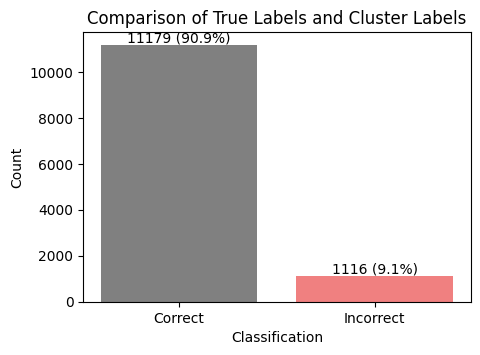

In [85]:
merged_df = merged_df.join(dfp[['cluster_label']])
merged_df['label'] = merged_df['label'].astype(int)
merged_df['cluster_label'] = merged_df['cluster_label'].astype(int)

merged_df['correct'] = merged_df['label'] == merged_df['cluster_label']
comparison_counts = merged_df['correct'].value_counts()
total_count = len(merged_df)

fig, ax = plt.subplots(figsize=(5, 3.5))
bars = ax.bar(comparison_counts.index.map({True: 'Correct', False: 'Incorrect'}),
              comparison_counts.values,
              color=['gray', 'lightcoral'])

ax.set_xlabel('Classification')
ax.set_ylabel('Count')
ax.set_title('Comparison of True Labels and Cluster Labels')

for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height} ({percentage:.1f}%)',
            ha='center', va='bottom')

plt.show()
